In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cooler
import cooltools
import coolpuppy
import gseapy as gp
import pingouin as pg
import bioframe as bf

from matplotlib_venn import venn2, venn3, venn2_circles, venn3_circles

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
RES = 2000

clr_path = {
    'NeuN+': "human_data/NeuNplus.sampled.1000.mcool",
    'NeuN-': "human_data/NeuNminus.sampled.1000.mcool"
}
clrs = {ct:
    cooler.Cooler(clr_path[ct] + f'::resolutions/{RES}') 
    for ct in ('NeuN+', 'NeuN-')}

# Отображение общей степени упаковки генома: scaling plot (contacts vs distance)

In [4]:
# Compute per-diagonal mean value (expected) 
cvd_smooth_agg = {}

for ct in ('NeuN+', 'NeuN-'):
    print(ct)
    cvd_smooth_agg[ct] = cooltools.expected_cis(
        clr=clrs[ct],
        smooth=True,
        aggregate_smoothed=True,
        nproc=2
    )

NeuN+
NeuN-


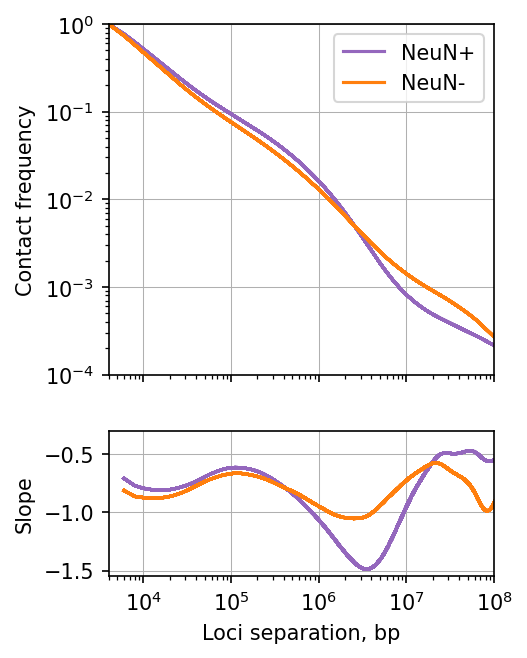

In [5]:
f, axs = plt.subplots(2, 1, dpi=150, sharex=True, gridspec_kw={'height_ratios':[3, 1]}, 
                      figsize=(3.4, 4.5), 
                      layout="constrained")

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

i=0
for ct in ('NeuN+', 'NeuN-'):
    # Add distance value and drop first two columns
    cvd_smooth_agg[ct].loc[:, 's_bp'] = cvd_smooth_agg[ct]['dist'] * RES
    cvd_smooth_agg[ct].loc[cvd_smooth_agg[ct]['dist'] < 2, 
                           'balanced.avg.smoothed.agg'] = np.nan
    
    # Normalize so that all lines start at 1
    cvd_smooth_agg[ct].loc[:, 'balanced.avg.smoothed.agg.norm'] = \
        cvd_smooth_agg[ct]['balanced.avg.smoothed.agg'] / \
        cvd_smooth_agg[ct]['balanced.avg.smoothed.agg'].values[2]

    # Calculate slope
    slope = np.gradient(np.log(cvd_smooth_agg[ct]['balanced.avg.smoothed.agg.norm']),
                      np.log(cvd_smooth_agg[ct]['s_bp']))

    # Plot scaling
    ax = axs[0]
    ax.loglog(
        cvd_smooth_agg[ct]['s_bp'],
        cvd_smooth_agg[ct]['balanced.avg.smoothed.agg.norm'],
        label=f"{ct}",
        color=colors[ct],
    )

    ax.set(ylabel='Contact frequency')
    ax.set_xlim([4000, 1e8])
    ax.set_ylim([1e-4, 1])
    ax.set_adjustable("box")
    ax.set_aspect(1)
    ax.grid(lw=0.5)
    ax.legend()

    # Plot slope
    ax = axs[1]
    ax.semilogx(
        cvd_smooth_agg[ct]['s_bp'],
        slope,
        color=colors[ct],
    )

    ax.set(
        xlabel='Loci separation, bp',
        ylabel='Slope',
    )

    ax.grid(lw=0.5)
    ax.set_xticks([1e4, 1e5, 1e6, 1e7, 1e8], minor=False)
    ax.set_ylim([-1.55, -0.3])

# Анализ компартментализации

In [7]:
import subprocess

if not os.path.isfile('./human_data/hg38.fa'):
    ## note downloading a ~1Gb file can take a minute
    subprocess.call('wget --progress=bar:force:noscroll https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz', shell=True)
    subprocess.call('gunzip hg38.fa.gz', shell=True)
    subprocess.call('mv hg38.fa ./human_data/hg38.fa', shell=True)

In [8]:
import matplotlib as mpl
import matplotlib.colors as mcolors

from cytoolz import merge
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap
from matplotlib import ticker
from matplotlib.ticker import EngFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

class MidPointLogNorm(LogNorm):
    """
    Borrowed from: https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

In [9]:

def saddleplot(
    track, saddledata, n_bins,
    vrange=None, qrange=(0.0, 1.0),
    cmap="coolwarm", scale="log",
    vmin=0.5, vmax=2, color=None,
    title=None, xlabel=None, ylabel=None,
    clabel=None, fig=None, fig_kws=None,
    heatmap_kws=None, margin_kws=None,
    cbar_kws=None, subplot_spec=None,
):
    """
    Function is taken from cooltools package
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt


    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]

    groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        groupmean = groupmean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.15, 1, 0.1],
        height_ratios=[0.15, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)
    plt.gca().set_aspect('equal', 'box')

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=0)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges, height=1/len(binedges), width=groupmean, align="edge", **margin_kws
    )

    plt.xlim([-1, 1])
    
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges, width=1/len(binedges), height=groupmean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    plt.ylim([-1, 1])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().xaxis.set_visible(False)

    # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(ax = grid["ax_cbar"], fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
    else:
        grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
        cb.ax.yaxis.set_major_locator(ticker.FixedLocator([round(vmin, 2), 1, round(vmax, 2)]))
        cb.ax.yaxis.set_minor_locator(ticker.FixedLocator([]))  

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    plt.grid(False)
    plt.axis("off")
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)
        
    return grid, C

In [10]:
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens_sad = bf.fetch_centromeres('hg38')

# Create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bf.make_chromarms(hg38_chromsizes,  hg38_cens_sad)
hg38_arms = hg38_arms.loc[~hg38_arms['name'].isin(['chr13_p', 'chr14_p', 'chr15_p', 'chr21_p', 
                                                   'chr22_p', 'chrY_p', 'chrY_q', 'chrM_p'])]\
                     .reset_index(drop=True)

In [11]:
RES = 50_000

clr_path = {
    'NeuN+': "human_data/NeuNplus.sampled.1000.mcool",
    'NeuN-': "human_data/NeuNminus.sampled.1000.mcool"
}

clrs = {ct:
    cooler.Cooler(clr_path[ct] + f'::resolutions/{RES}') 
    for ct in ('NeuN+', 'NeuN-')}

cts = list(clrs)

## Расчет собственных значений и собственных векторов матрицы Hi-C

In [12]:
hg38_genome = bf.load_fasta('./human_data/hg38.fa')
cis_eigs = {}

for ct in clrs:
    
    bins = clrs[ct].bins()[:]
    gc_cov = bf.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
    
    cis_eigs[ct] = cooltools.eigs_cis(
                                      clrs[ct], gc_cov,
                                      view_df=hg38_arms,
                                      n_eigs=2,
                                      sort_metric='spearmanr'
                                    )

eig_df = cis_eigs[list(clrs)[0]][1][['chrom', 'start', 'end']]

for ct in clrs:
    df = cis_eigs[ct][1][['chrom','start','end','E1', 'E2']]\
        .rename(columns={'E1': f'E1.{ct}', 'E2': f'E2.{ct}'})
    eig_df = eig_df.merge(df, on=['chrom', 'start', 'end'], validate="1:1")
            
print(eig_df.shape)
eig_df.head()

(59012, 7)


chrom   start     end  E1.NeuN+  E2.NeuN+  E1.NeuN-  E2.NeuN-
0  chr1       0   50000       NaN       NaN       NaN       NaN
1  chr1   50000  100000       NaN       NaN       NaN       NaN
2  chr1  100000  150000       NaN       NaN       NaN       NaN
3  chr1  150000  200000       NaN       NaN       NaN       NaN
4  chr1  200000  250000       NaN       NaN       NaN       NaN

In [13]:
bp_formatter = EngFormatter('b')


def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1e7))
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1e7))
        ax.xaxis.tick_bottom()


class MinOneMaxFormatter(ticker.LogFormatter):
    def set_locs(self, locs=None):
        self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])
 
    def __call__(self, x, pos=None):
        if x not in [vmin, 1, vmax]:
            return ""
        else:
            return "{x:g}".format(x=x)

Text(0, 0.5, 'Contact probability')

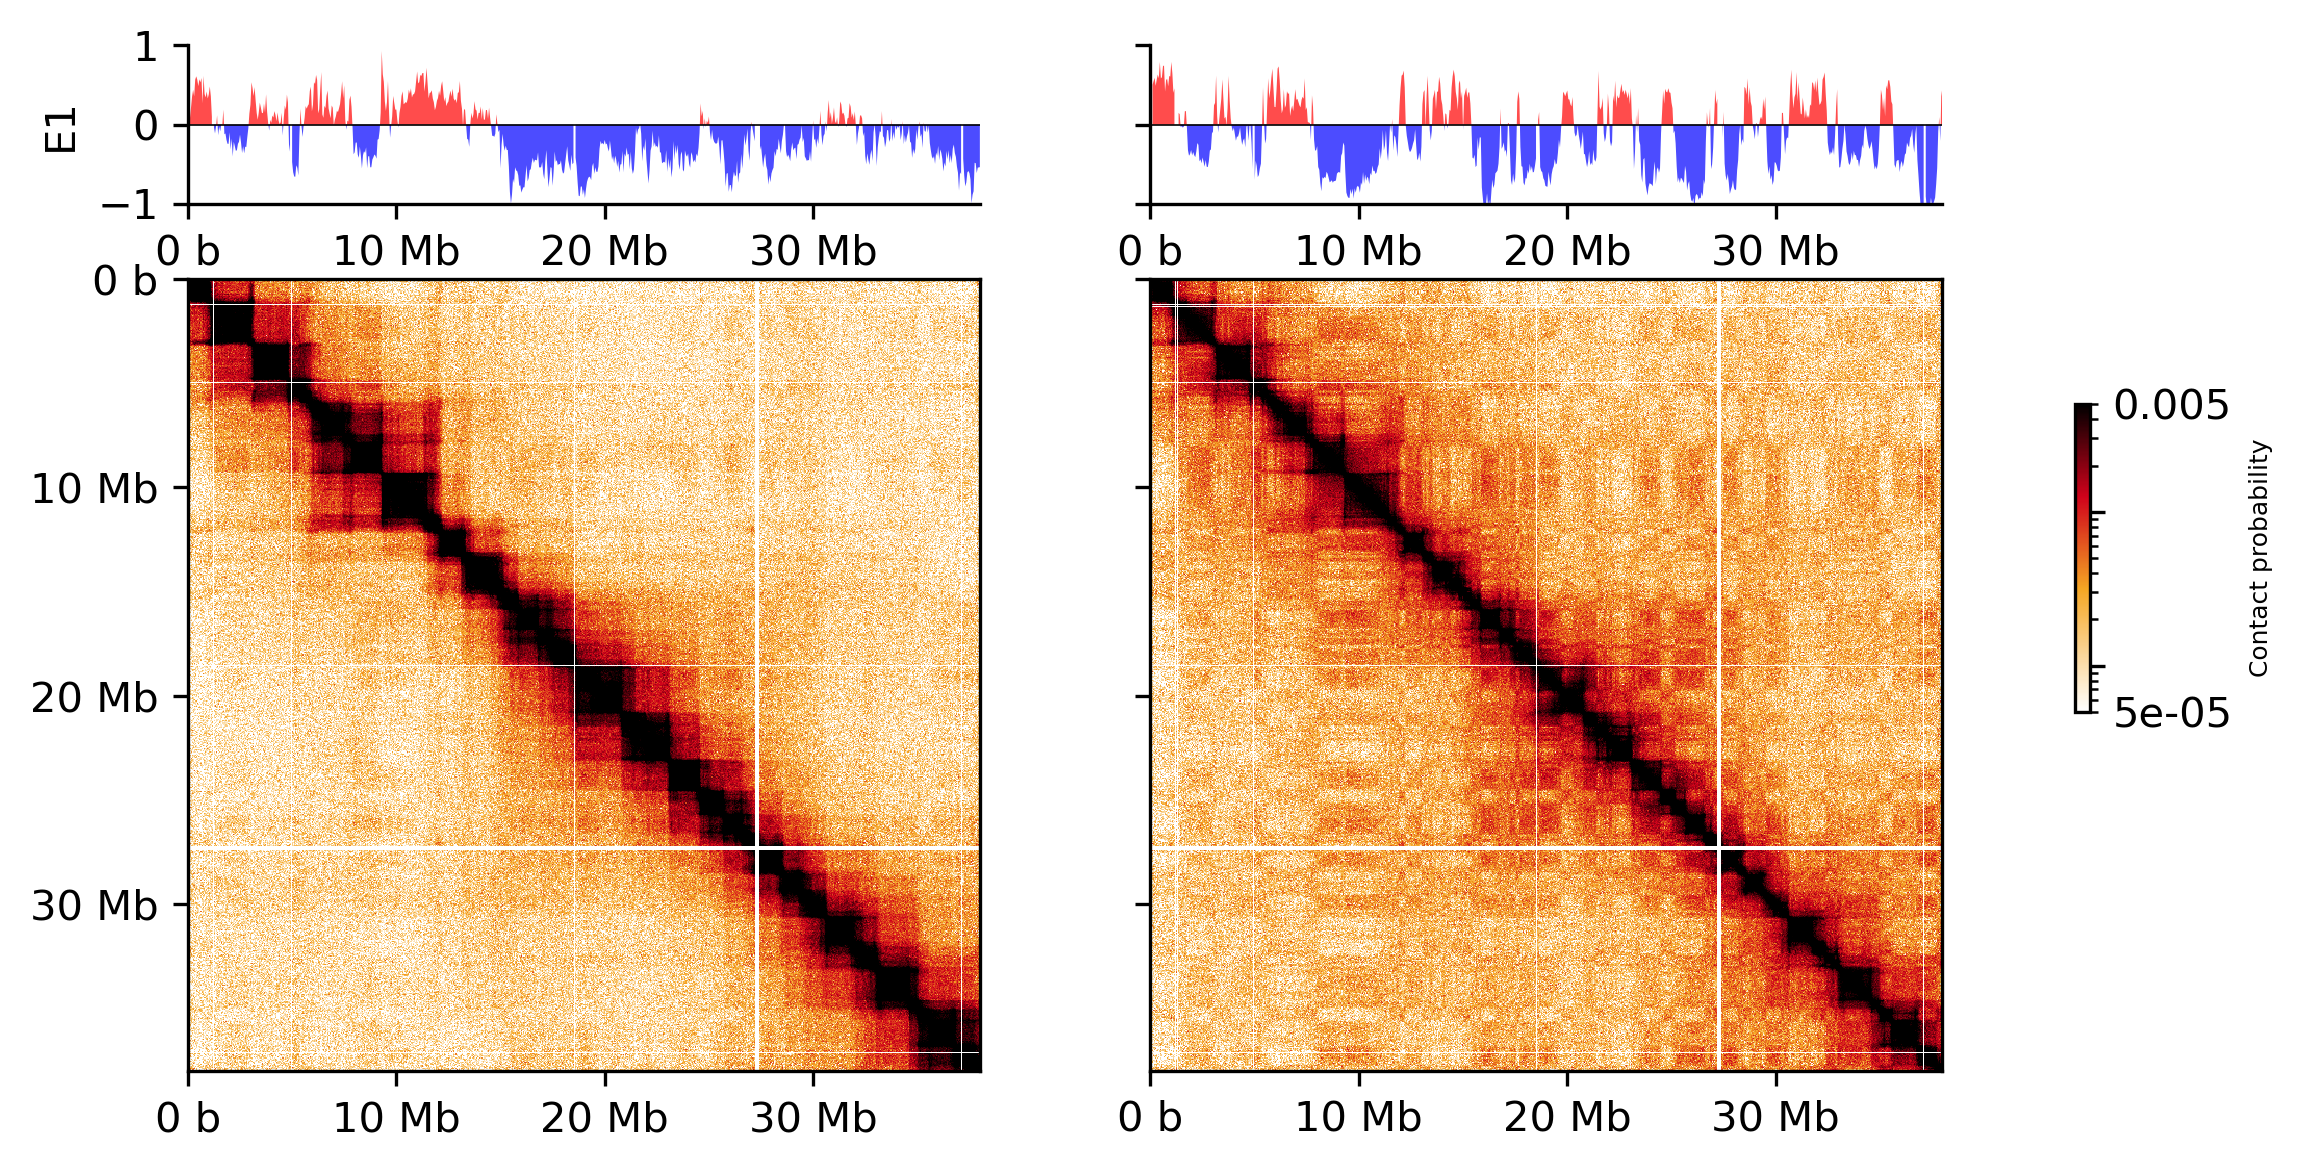

In [14]:
# Draw eigenvectors        

f, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, dpi=300, layout='tight')

# Create custom colormap
cmap_colors = np.array([
    [255, 255, 255, 255],
    [245, 166, 35, 255],
    [208, 2, 27, 255],
    [0, 0, 0, 255]
]) / 255
cmap_nodes = [0, 0.4, 0.7, 1]
cust_cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(cmap_nodes, cmap_colors)))

vmin, vmax = 5e-5, 0.005
norm = LogNorm(vmin=vmin, vmax=vmax)

start, end = 0, 38_000_300

reg = ('chr10', start, end)
eig_df_reg = eig_df.loc[clrs[ct].bins().fetch(reg).index]
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

for i, ct in enumerate(['NeuN+', 'NeuN-']):
    im = axs[i].matshow(
        clrs[ct].matrix().fetch(reg),
        norm=norm,
        cmap=cust_cmap,
        extent=(start, end, end, start)
    );
    
    divider = make_axes_locatable(axs[i])
    format_ticks(axs[i])

    ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=axs[i])
    ax1.plot([start, end], [0,0], 'k', lw=0.4)
    
    eig = 'E1'
    ax1.fill_between(np.arange(start, end, RES), 
                     eig_df_reg[f'{eig}.{ct}'].values, 0, 
                     where=eig_df_reg[f'{eig}.{ct}'].values >= 0, 
                     facecolor='red', interpolate=True, alpha=0.7)
    ax1.fill_between(np.arange(start, end, RES), 
                     eig_df_reg[f'{eig}.{ct}'].values, 0, 
                     where=eig_df_reg[f'{eig}.{ct}'].values <= 0, 
                     facecolor='blue', interpolate=True, alpha=0.7)
    ax1.set_xlim([start, end])
    ax1.set_ylim([-1, 1])
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    if i == 0:
        ax1.set_ylabel('E1')
    if i == 1:
        ax1.yaxis.set_ticklabels([])
    
cb = plt.colorbar(im, ax=axs[1], format=MinOneMaxFormatter(), shrink=0.3)
cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())
cb.ax.set_ylabel('Contact probability', fontsize=6, rotation=90)

## Усредненная картина компартментализации: saddle plot

In [15]:
%%time 

cvd = {ct: {} for ct in cts}

for ct in cts:
    print(ct)
    cvd[ct] = cooltools.expected_cis(
                                    clrs[ct],
                                    view_df=hg38_arms,
                                    smooth=False,
                                    nproc=2
                                )

NeuN+
NeuN-
CPU times: user 1.28 s, sys: 162 ms, total: 1.45 s
Wall time: 1min 14s


In [16]:
interaction_sum = {ct: {} for ct in cts}
interaction_count = {ct: {} for ct in cts}
saddle_nbins = 50

for ct in cts:
        interaction_sum[ct], interaction_count[ct] = cooltools.saddle(
            clrs[ct],
            cvd[ct],
            eig_df[['chrom','start','end', f'E1.{ct}']], 'cis',
            n_bins=saddle_nbins,
            qrange=(0.025, 0.975),
            view_df=hg38_arms,
            min_diag=4,
        )

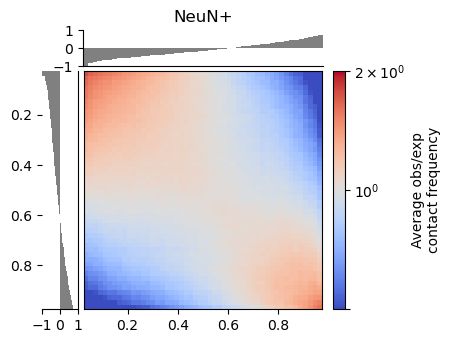

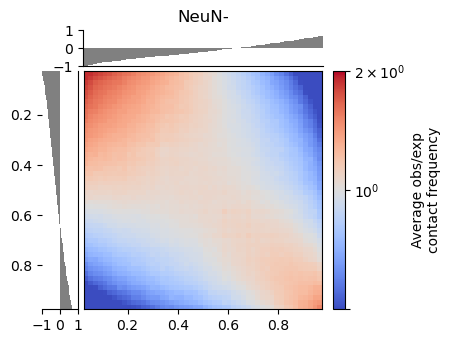

In [17]:
sp ={}
for ct in cts:
        plot, sp[ct] =  saddleplot(
            eig_df[['chrom','start','end', f'E1.{ct}']],
            interaction_sum[ct] / interaction_count[ct],
            saddle_nbins,
            cmap='RdBu_r',
            qrange=(0.025, 0.975),
            cbar_kws={'label':'Average obs/exp\ncontact frequency'},
            fig_kws={'dpi': 100, 'figsize': [4, 4]},
            title=ct,
            scale='log',
            vmin=1/2, vmax=2,
            margin_kws={'facecolor': 'grey'}
        );

## Численная характеристика saddle-plot'a - saddle strength

Text(0.5, 1.0, 'Interaction strength')

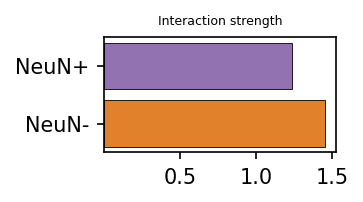

In [21]:
figs = []
labels = ['Intra / Inter']
x = np.arange(len(labels))
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}
nbins_corner = saddle_nbins // 5

ct_arr, group_arr, strnth_arr = [], [], []
for ct in cts:
    ct_arr.extend([ct])

    mat = (interaction_sum[ct] / interaction_count[ct])[1:-1, 1:-1]
    AB = np.nanmean(mat[:nbins_corner, -nbins_corner:])
    AABB = np.nanmean([mat[-nbins_corner:, -nbins_corner:], 
                       mat[:nbins_corner, :nbins_corner]])

    group_arr.append(u'Intra / Inter')
    strnth_arr.append(AABB / AB - 1)

plot_df = pd.DataFrame(data={
    'ct': ct_arr,
    'group': group_arr,
    'strnth': strnth_arr
})

plt.figure(figsize=(2, 1), dpi=150)
sns.barplot(data=plot_df, x='strnth', y='ct', ci=None,
            linewidth=0.4, edgecolor='k', palette=colors)
plt.xticks([0.5, 1, 1.5],
           rotation=0, ha='center')

plt.xlabel('')
plt.ylabel('')
plt.title('Interaction strength', fontsize=6)

# Разметка ТАДов

In [22]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [23]:
RES = 10_000

clr_path = {
    'NeuN+': "human_data/NeuNplus.sampled.1000.mcool",
    'NeuN-': "human_data/NeuNminus.sampled.1000.mcool"
}

clrs = {ct:
    cooler.Cooler(clr_path[ct] + f'::resolutions/{RES}') 
    for ct in ('NeuN+', 'NeuN-')}

In [24]:
clr = clrs['NeuN+']

In [25]:
%%time

windows = [5*RES, 10*RES, 25*RES, 50*RES]
insulation_table = cooltools.insulation(clr, windows, nproc=2, verbose=False)

CPU times: user 7.66 s, sys: 198 ms, total: 7.86 s
Wall time: 6min 56s


(2000000.0, 8000000.0)

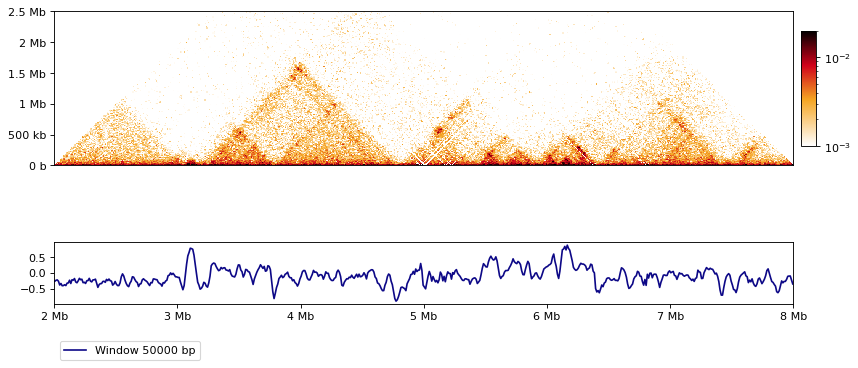

In [26]:
f, ax = plt.subplots(figsize=(18, 6), dpi=80)

norm = LogNorm(vmax=0.02, vmin=0.001)

start = 2_000_000
end = start+ 120*windows[0]
region = ('chr10', start, end)
data = clr.matrix(balance=True).fetch(region)

im = pcolormesh_45deg(ax, data, start=region[1], resolution=RES, norm=norm, cmap=cust_cmap)
ax.set_aspect(0.5)
ax.set_ylim(0, 50*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bf.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="20%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region['log2_insulation_score_'+str(windows[0])],
            label=f'Window {windows[0]} bp')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

In [27]:
for res in windows[1:]:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'Window {res} bp')
ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

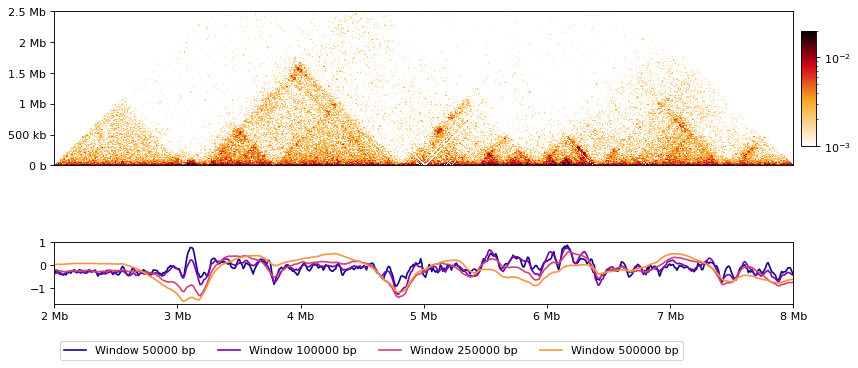

In [28]:
f

(2000000.0, 8000000.0)

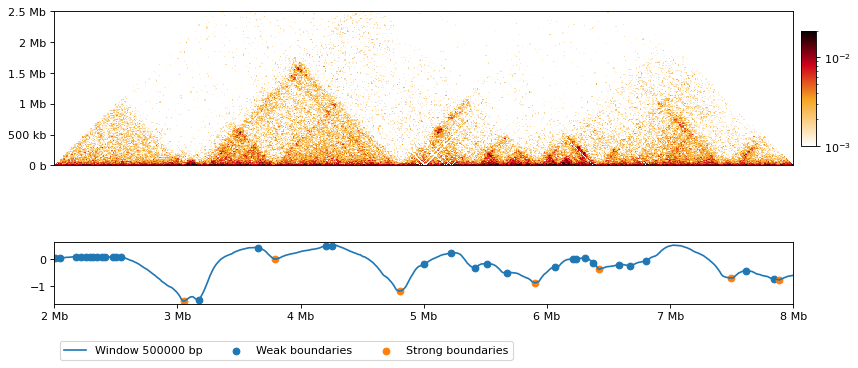

In [29]:
f, ax = plt.subplots(figsize=(18, 6), dpi=80)

im = pcolormesh_45deg(ax, data, start=region[1], resolution=RES, norm=norm, cmap=cust_cmap)
ax.set_aspect(0.5)
ax.set_ylim(0, 50*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bf.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="20%", pad=0., sharex=ax)

window = windows[3]

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{window}'], label=f'Window {window} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{window}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{window}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{window}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{window}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{window}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

In [30]:
strong_boundaries[[column for column in strong_boundaries.columns if '_' not in column or str(window) in column]]

chrom    start      end region  log2_insulation_score_500000  \
167797  chr10  3050000  3060000  chr10                     -1.550949   
167871  chr10  3790000  3800000  chr10                     -0.000523   
167972  chr10  4800000  4810000  chr10                     -1.177005   
168082  chr10  5900000  5910000  chr10                     -0.870367   
168134  chr10  6420000  6430000  chr10                     -0.374023   
168241  chr10  7490000  7500000  chr10                     -0.698273   
168280  chr10  7880000  7890000  chr10                     -0.764344   

        n_valid_pixels_500000  boundary_strength_500000  is_boundary_500000  
167797                 2497.0                  2.065177                True  
167871                 2497.0                  0.428248                True  
167972                 2247.0                  1.690728                True  
168082                 2447.0                  1.101266                True  
168134                 2398.0                  0.410341                True  
168241                 2497.0                  0.271085                True  
168280                 2497.0                  0.902770                True

# Разметка петель

In [31]:
# create a functions that would return a series of rectangles around called dots
# in a specific region, and exposing importnat plotting parameters
def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none"):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bf.select(
        bf.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = e1 - s1
        width2 = e2 - s2
        if loc == "upper":
            yield patches.Rectangle((s2, s1), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((s1, s2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

In [32]:
RES = 10_000

clr_path = {
    'NeuN+': "human_data/NeuNplus.sampled.1000.mcool",
    'NeuN-': "human_data/NeuNminus.sampled.1000.mcool"
}

clrs = {ct:
    cooler.Cooler(clr_path[ct] + f'::resolutions/{RES}') 
    for ct in ('NeuN+', 'NeuN-')}

In [33]:
clr = clrs['NeuN+']

In [34]:
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens = bf.fetch_centromeres('hg38')
hg38_arms = bf.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler.
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()

# intra-arm expected
expected = cooltools.expected_cis(
    clr,
    view_df=hg38_arms,
    nproc=2,
)

In [36]:
%%time

dots_df = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=2, 
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root:convolving 1781 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 2 workers to tackle 1781 tiles
INFO:root:Done building histograms in 230.125 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 1781 tiles to extract enriched pixels
INFO:root:creating a Pool of 2 workers to tackle 1781 tiles
INFO:root:Done extracting enriched pixels in 191.479 sec ...
INFO:root:Begin post-processing of 10301 filtered pixels
INFO:root:preparing to extract needed q-values ...
INFO:root:clustering enriched pixels in region: chr10_p
INFO:root:detected 97 clusters of 1.54+/-0.94 size
INFO:root:clustering enriched pixels in region: chr10_q
INFO:root:detected 224 clusters of 1.62+/-1.06 size
INFO:root:clustering enriched pixels in region: chr11_p
INFO:root:detected 114 clusters of 1.86+/-1.26 size
INFO:root:clustering enriched pixels in region: chr11_q
INFO:root:dete

CPU times: user 24.2 s, sys: 10.2 s, total: 34.4 s
Wall time: 7min 4s


In [37]:
from cooltools.lib.numutils import fill_diag
import matplotlib.patches as patches

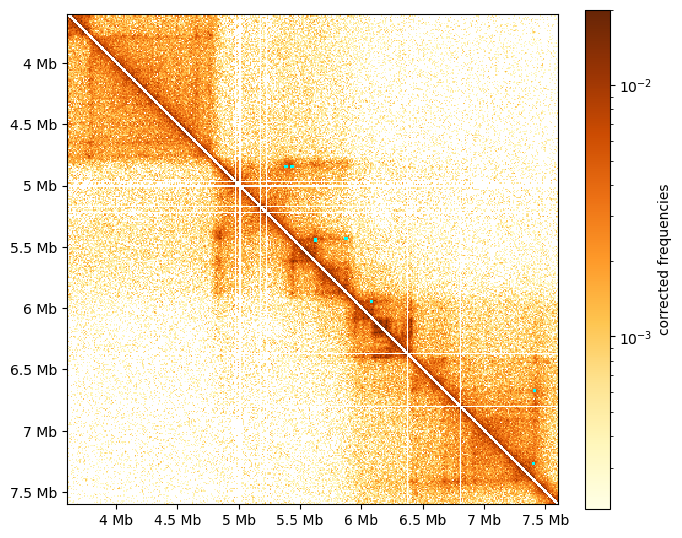

In [38]:
start = 3_600_000
end = start + 4_000_000
region = ('chr10', start, end)

# heatmap kwargs
matshow_kwargs = dict(
    cmap='YlOrBr',
    norm=LogNorm(vmax=0.02),
    extent=(start, end, end, start)
)

# colorbar kwargs
colorbar_kwargs = dict(fraction=0.046, label='corrected frequencies')

# compute heatmap for the region
region_matrix = clr.matrix(balance=True).fetch(region)
for diag in [-1,0,1]:
    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow( region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df, region, lw=1.5):
    ax.add_patch(box)

In [39]:
%%time

dots_df = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=2,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root:convolving 1781 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 2 workers to tackle 1781 tiles
INFO:root:Done building histograms in 228.989 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 1781 tiles to extract enriched pixels
INFO:root:creating a Pool of 2 workers to tackle 1781 tiles
INFO:root:Done extracting enriched pixels in 187.101 sec ...
INFO:root:Begin post-processing of 10301 filtered pixels
INFO:root:preparing to extract needed q-values ...
INFO:root:clustering enriched pixels in region: chr10_p
INFO:root:detected 97 clusters of 1.54+/-0.94 size
INFO:root:clustering enriched pixels in region: chr10_q
INFO:root:detected 224 clusters of 1.62+/-1.06 size
INFO:root:clustering enriched pixels in region: chr11_p
INFO:root:detected 114 clusters of 1.86+/-1.26 size
INFO:root:clustering enriched pixels in region: chr11_q
INFO:root:dete

CPU times: user 22.3 s, sys: 8.02 s, total: 30.3 s
Wall time: 6min 58s


## Разметка петель с кастомным ядром

In [40]:
kernels = cooltools.api.dotfinder.recommend_kernels(RES)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000


In [41]:
half = 5  # half width of the kernel
x, y = np.meshgrid(
    np.linspace(-half, half, 2*half + 1),
    np.linspace(-half, half, 2*half + 1),
)
# now define a donut-like mask as pixels between 2 radii: sqrt(7) and sqrt(30):
mask = (x**2+y**2 > 7) & (x**2+y**2 <= 30)
mask[:,half] = 0
mask[half,:] = 0

# lowleft mask - zero out neccessary parts
mask_ll = mask.copy()
mask_ll[:,:half] = 0
mask_ll[half:,:] = 0

# new kernels with more round donut and lowleft masks:
kernels_round = {'donut': mask,
 'vertical': kernels["vertical"].copy(),
 'horizontal': kernels["horizontal"].copy(),
 'lowleft': mask_ll}

In [42]:
dots_df_all = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    max_loci_separation=10_000_000,
    clustering_radius=None,
    nproc=2,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root:convolving 1781 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 2 workers to tackle 1781 tiles
INFO:root:Done building histograms in 229.360 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 1781 tiles to extract enriched pixels
INFO:root:creating a Pool of 2 workers to tackle 1781 tiles
INFO:root:Done extracting enriched pixels in 186.627 sec ...
INFO:root:Begin post-processing of 10301 filtered pixels
INFO:root:preparing to extract needed q-values ...


In [43]:
dots_round_df_all = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    kernels=kernels_round, # provide custom kernels
    max_loci_separation=10_000_000,
    clustering_radius=None,
    nproc=2,
)

INFO:root:convolving 1781 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 8 workers to tackle 1781 tiles
INFO:root:Done building histograms in 65.393 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 1781 tiles to extract enriched pixels
INFO:root:creating a Pool of 8 workers to tackle 1781 tiles
INFO:root:Done extracting enriched pixels in 47.313 sec ...
INFO:root:Begin post-processing of 10087 filtered pixels
INFO:root:preparing to extract needed q-values ...


In [44]:
from itertools import chain

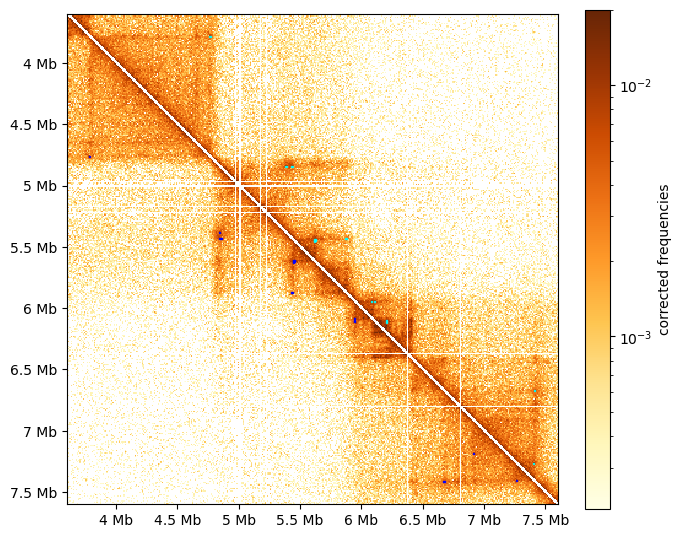

In [45]:
f, ax = plt.subplots(figsize=(7,7))
# draw heatmap
im = ax.matshow(region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in chain(
        rectangles_around_dots(dots_round_df_all, region),
        rectangles_around_dots(dots_df_all, region, loc="lower", ec="blue"),
    ):
    ax.add_patch(rect)

## Сравнение петель между двумя картами

In [46]:
loops = {}
for ct, clr in clrs.items():
    expected = cooltools.expected_cis(clr, view_df=hg38_arms, nproc=2)
    loops[ct] = cooltools.dots(
                             clr, expected=expected, view_df=hg38_arms,
                             max_loci_separation=10_000_000, nproc=2,
                            )

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root:convolving 1781 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 2 workers to tackle 1781 tiles
INFO:root:Done building histograms in 229.535 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 1781 tiles to extract enriched pixels
INFO:root:creating a Pool of 2 workers to tackle 1781 tiles
INFO:root:Done extracting enriched pixels in 187.092 sec ...
INFO:root:Begin post-processing of 10301 filtered pixels
INFO:root:preparing to extract needed q-values ...
INFO:root:clustering enriched pixels in region: chr10_p
INFO:root:detected 97 clusters of 1.54+/-0.94 size
INFO:root:clustering enriched pixels in region: chr10_q
INFO:root:detected 224 clusters of 1.62+/-1.06 size
INFO:root:clustering enriched pixels in region: chr11_p
INFO:root:detected 114 clusters of 1.86+/-1.26 size
INFO:root:clustering enriched pixels in region: chr11_q
INFO:root:dete

In [47]:
coords_cols = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

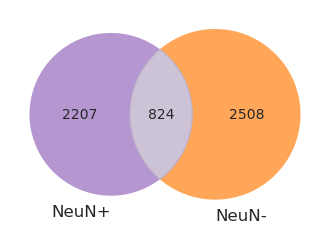

In [48]:
sns.set_style("white")
plt.figure(figsize=(4,4))
my_pal = {"NeuN+": sns.color_palette()[4], "NeuN-":sns.color_palette()[1]}

c = venn2([set(loops[ct][coords_cols].apply(lambda coords: '_'.join([str(x) for x in coords]), axis=1).values) for ct in clrs], 
          set_labels = ('NeuN+', 'NeuN-'),
         set_colors=(sns.color_palette()[4],sns.color_palette()[1]),alpha=0.69)
c.get_patch_by_id('11').set_color('#b7a9c4')
plt.show()

## Отбираем топ 50 наиболее измененных петель

In [49]:
top_changed_dots = pd.merge(loops['NeuN+'], loops['NeuN-'], 
                             how='inner', on=coords_cols) \
                            .set_index(coords_cols) \
                            .apply(lambda x: x['la_exp.donut.value_x'] / x['la_exp.donut.value_y'] , axis=1) \
                            .nlargest(50).index.to_list()

In [51]:
top_changed_dots[:3]

[('chr10', 132220000, 132230000, 'chr10', 132450000, 132460000),
 ('chr9', 17530000, 17540000, 'chr9', 17800000, 17810000),
 ('chr5', 175530000, 175540000, 'chr5', 175710000, 175720000)]

Соответствующие им основания:

In [52]:
anchors = pd.DataFrame(set([dot[:3] for dot in top_changed_dots] + [dot[3:] for dot in top_changed_dots]), columns=['chrom', 'start', 'end'])

## Добавляем аннотацию генов в основаниях выбранных петель

In [53]:
gff_colnames = ('chrom', 'DB', 'type', 'start', 'end', '_', 'strand', '__', 'data')
annotation = pd.read_csv('human_data/gencode.v44.annotation.gff3', sep='\t', header=None, comment='#', names=gff_colnames)
annotation['gene_name'] = annotation['data'].str.extract(r'gene_name=([^;]+)', expand=False)
annotation['gene_type'] = annotation['data'].str.extract(r'gene_type=([^;]+)', expand=False)
annotation['gene_id'] = annotation['data'].str.extract(r'gene_id=([^;]+)', expand=False)
annotation = annotation[['chrom', 'start', 'end', 'gene_name', 'gene_type', 'strand', 'type', 'gene_id']]
annotation = annotation.sort_values(by=['chrom', 'start', 'end', 'gene_name'], ascending=True)
annotation = annotation.dropna(subset=['chrom', 'start', 'end'])
annotation.start = annotation.start.astype(np.int64)
annotation.end = annotation.end.astype(np.int64)

In [54]:
# select genes promoters

PROMOTER_RANGE_UP = 1000
PROMOTER_RANGE_DOWN = 100

promoters_plus = annotation.query('type=="gene" and strand =="+"')[['chrom', 
                                                                    'start', 
                                                                    'gene_type',
                                                                    'gene_id',
                                                                    'gene_name']].rename({'start':'end'}, 
                                                                                         axis=1)
promoters_plus['start'] = promoters_plus['end'] - PROMOTER_RANGE_UP
promoters_plus['end'] = promoters_plus['end'] + PROMOTER_RANGE_DOWN

promoters_minus = annotation.query('type=="gene" and strand =="-"')[['chrom', 
                                                                     'end', 
                                                                     'gene_type',
                                                                     'gene_id',
                                                                     'gene_name']].rename({'end':'start'}, 
                                                                                          axis=1)
promoters_minus['end'] = promoters_minus['start'] + PROMOTER_RANGE_UP
promoters_minus['start'] = promoters_minus['start'] - PROMOTER_RANGE_DOWN

promoters = pd.concat([promoters_plus, promoters_minus])[['chrom', 'start', 'end', 'gene_type', 'gene_id', 'gene_name']]

In [55]:
anchors = bf.overlap(anchors, promoters, how='left', suffixes=('','_anno'))

In [56]:
anchors = anchors.dropna(subset='gene_name_anno')[['chrom', 'start', 'end', 'gene_name_anno']]

In [57]:
anchors

chrom      start        end   gene_name_anno
1     chr6  123800000  123810000           NKAIN2
8     chr2   10830000   10840000            PDIA6
9    chr18   46650000   46660000           LOXHD1
10    chr2  232850000  232860000            SNORC
11    chr1   18100000   18110000           IGSF21
12    chr1   18100000   18110000  ENSG00000280222
15    chr8   74340000   74350000  ENSG00000253596
19   chr15   39780000   39790000            FSIP1
20   chr15   39780000   39790000  ENSG00000261136
23    chr7   31120000   31130000  ENSG00000232887
31    chr3   13640000   13650000        LINC00620
32   chr13  109780000  109790000             IRS2
33   chr13  109780000  109790000  ENSG00000275741
34   chr11  124410000  124420000  ENSG00000285561
47   chr11  125160000  125170000        PKNOX2-DT
48   chr11  125160000  125170000           PKNOX2
50   chr11   99010000   99020000            CNTN5
57    chr8   73970000   73980000             ELOC
58    chr8   73970000   73980000           TMEM70
60   chr18   46170000   46180000         C18orf25
101  chr16   86510000   86520000           FENDRR
102  chr16   86510000   86520000            FOXF1
104  chr12   51420000   51430000       SLC4A8-AS1

In [58]:
def to_list(xs):
    xs = list(xs)
    return list(set([x for x in xs if x is not None]))
anchors.groupby(['chrom', 'start', 'end']).agg({'gene_name_anno': to_list}).reset_index()

chrom      start        end             gene_name_anno
0    chr1   18100000   18110000  [ENSG00000280222, IGSF21]
1   chr11   99010000   99020000                    [CNTN5]
2   chr11  124410000  124420000          [ENSG00000285561]
3   chr11  125160000  125170000        [PKNOX2, PKNOX2-DT]
4   chr12   51420000   51430000               [SLC4A8-AS1]
5   chr13  109780000  109790000    [IRS2, ENSG00000275741]
6   chr15   39780000   39790000   [ENSG00000261136, FSIP1]
7   chr16   86510000   86520000            [FENDRR, FOXF1]
8   chr18   46170000   46180000                 [C18orf25]
9   chr18   46650000   46660000                   [LOXHD1]
10   chr2   10830000   10840000                    [PDIA6]
11   chr2  232850000  232860000                    [SNORC]
12   chr3   13640000   13650000                [LINC00620]
13   chr6  123800000  123810000                   [NKAIN2]
14   chr7   31120000   31130000          [ENSG00000232887]
15   chr8   73970000   73980000             [TMEM70, ELOC]
16   chr8   74340000   74350000          [ENSG00000253596]

## Строим среднюю петлю (pileup) для выбранных петель

In [59]:
top_changed_dots_df = pd.DataFrame(top_changed_dots, columns=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2'])
top_changed_dots_df['strand1'] = '+'
top_changed_dots_df['strand2'] = '+'

In [60]:
%%time 

pileups = {}
for ct, clr in clrs.items():
    stack = cooltools.pileup(clr, top_changed_dots_df, 
                             view_df=hg38_arms, expected_df=expected, 
                             flank=200_000)
    
    pileups[ct] = np.nanmean(stack, axis=0)

CPU times: user 47.7 s, sys: 1.1 s, total: 48.8 s
Wall time: 49 s


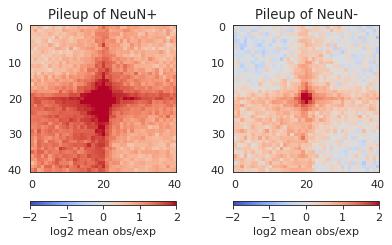

In [61]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 3), dpi=80)

for ax, (ct, mtx) in zip(axs, pileups.items()):
    im = ax.imshow(np.log2(mtx),
        vmax = 2, vmin = -2,
        cmap='coolwarm')

    ax.set_title(f'Pileup of {ct}')
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("bottom", size="10%", pad=0.3, aspect=0.1)
    plt.colorbar(im, cax=cax, label = 'log2 mean obs/exp', orientation='horizontal')
    